# Mid-Term Project: Multi-Constraint Portfolio Allocation — EXEMPLAR

**Student Name:** Course Instructor (Exemplar)
**Date:** February 2025
**Chosen context:** Marketing – ad spend across channels
**Field:** Marketing / Digital advertising

## Project Overview

You will choose a resource allocation problem in your field, create a synthetic dataset with **8–10 options**, build a **multi-constraint optimization model**, explore **near-optimal alternatives**, run deep sensitivity analysis and validation, then respond to **two stakeholder changes of mind**. The deliverable is one notebook with clear documentation and an executive summary suitable to hand off to a manager.

**Learning Objectives:**
- Build a multi-constraint continuous LP in PuLP (budget cap, category coverage, concentration cap)
- Diagnose and handle infeasibility when constraints interact
- Identify near-optimal alternative solutions and explain why they might be preferred
- Perform sensitivity analysis across 5 parameters at ±20% and ±40%
- Apply extreme value testing and one additional what-if scenario
- Validate the solution with sanity checks and a fragile vs. robust assessment
- Respond to two stakeholder changes of mind with updated models and a three-way comparison
- Communicate findings in an executive summary suitable for a non-technical decision-maker

In [16]:
# Install required packages (if needed in Colab)
# Skip if running locally and packages are already installed
%pip install pulp pandas matplotlib numpy -q


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpMinimize, LpProblem, LpVariable, lpSum, value, LpStatus, PULP_CBC_CMD
import io

print("Libraries imported successfully!")

Libraries imported successfully!


---
## Creating Your Synthetic Dataset

Your dataset must have **8–10 rows** (one row per option) and **4 columns**:

1. **option** — a name or label for each option (e.g. "Channel_A", "Program_ICU")
2. **category** — which of exactly **3 logical groups** this option belongs to (e.g. "Paid", "Organic", "Brand"). Every option must belong to one group. You must have at least one option per group.
3. **benefit_rate** — the expected return per unit allocated. This is the coefficient in your objective function. Use a decimal (e.g. 0.04 = 4 cents returned per dollar spent).
4. **[your_field_column]** — one additional numeric attribute meaningful in your field (e.g. `quality_score`, `risk_rating`, `reach_index`). Rename this column to match your context.

You will also set **three global constraint values** in your code (not in the CSV):

- `budget_total` — total resource available (e.g. $50,000 or 2,000 staff-hours)
- `min_alloc_per_category` — minimum each of the 3 categories must receive (ensures balanced portfolio)
- `concentration_cap` — maximum fraction any single option can receive (e.g. 0.35 = no option gets more than 35% of the total budget)

**Feasibility check before you start:** Confirm that `min_alloc_per_category × 3 < budget_total` and `concentration_cap × budget_total > min_alloc_per_category`. If not, your model will be infeasible immediately — adjust the values.

**Step-by-step LLM prompt:**

1. Open a **new** conversation with ChatGPT, Claude, or Copilot.
2. Say: "I need a synthetic dataset for a prescriptive analytics portfolio allocation problem. I will use Python with pandas and PuLP. I need the output as **CSV only**."
3. Tell it your field: "I am modeling [your decision, e.g. 'marketing ad spend across channels']."
4. Say: "Create a CSV with **exactly [8, 9, or 10] rows** and these exact columns: `option` (name), `category` (one of exactly 3 groups — use these names: [name your 3 groups]), `benefit_rate` (decimal, e.g. 0.02 to 0.09, realistic for my context), `[your_field_column]` (numeric, realistic). Use realistic but simple numbers. Also give me three constraint values: `budget_total`, `min_alloc_per_category`, `concentration_cap`. Output only the CSV and the three values; no other text."
5. Copy the CSV and paste it below. Set the three constraint values in the code cell.

In [18]:
# Paste your CSV here and set the three constraint values.
# Replace the example below with your actual data from the LLM.

csv_string = """
option,category,benefit_rate,quality_score
Channel_A,Paid,0.055,8.2
Channel_B,Paid,0.042,7.5
Channel_C,Paid,0.038,6.9
Channel_D,Organic,0.071,9.1
Channel_E,Organic,0.049,7.8
Channel_F,Organic,0.033,6.4
Channel_G,Brand,0.062,8.8
Channel_H,Brand,0.044,7.1
Channel_I,Brand,0.028,5.9
"""

options_df = pd.read_csv(io.StringIO(csv_string.strip()))

# Three global constraint values — set these based on what the LLM gave you
budget_total         = 50000   # Total resource available (e.g. dollars, hours)
min_alloc_per_category = 5000  # Each category must receive at least this much
concentration_cap    = 0.35    # No single option gets more than this fraction of budget_total

# Derived check value (used later)
max_single_alloc = concentration_cap * budget_total

# ── Display ────────────────────────────────────────────────────────────────────
print(options_df.to_string(index=False))
print(f"\nNumber of options: {len(options_df)}")
print(f"Number of categories: {options_df['category'].nunique()} — {list(options_df['category'].unique())}")
print(f"\nConstraint values:")
print(f"  budget_total           = {budget_total:,}")
print(f"  min_alloc_per_category = {min_alloc_per_category:,}")
print(f"  concentration_cap      = {concentration_cap} (max single option = {max_single_alloc:,.0f})")

# Quick feasibility pre-check
feasibility_ok = (min_alloc_per_category * 3 < budget_total) and (max_single_alloc >= min_alloc_per_category)
print(f"\nPre-check: {'✓ Constraint values look feasible' if feasibility_ok else '⚠ WARNING: constraint values may cause immediate infeasibility — adjust before proceeding'}")

   option category  benefit_rate  quality_score
Channel_A     Paid         0.055            8.2
Channel_B     Paid         0.042            7.5
Channel_C     Paid         0.038            6.9
Channel_D  Organic         0.071            9.1
Channel_E  Organic         0.049            7.8
Channel_F  Organic         0.033            6.4
Channel_G    Brand         0.062            8.8
Channel_H    Brand         0.044            7.1
Channel_I    Brand         0.028            5.9

Number of options: 9
Number of categories: 3 — ['Paid', 'Organic', 'Brand']

Constraint values:
  budget_total           = 50,000
  min_alloc_per_category = 5,000
  concentration_cap      = 0.35 (max single option = 17,500)

Pre-check: ✓ Constraint values look feasible


**Data documentation:** This synthetic dataset was generated with a language model (Claude). It contains 9 marketing channels in three categories (Paid, Organic, Brand), with columns option, category, benefit_rate, and quality_score. Constraint values used: budget_total = 50,000, min_alloc_per_category = 5,000, concentration_cap = 0.35.

---
## Part 1: Problem Framing and Dataset

### 1.1 Decision Statement

**Instructions:** Write a clear decision statement in the form: "I need to decide how to allocate [resource] across [options], subject to [constraints], in order to [objective]."

**Your Decision Statement:** I need to decide how to allocate the quarterly marketing budget ($50,000) across nine advertising channels (three Paid, three Organic, three Brand), subject to a minimum spend per category ($5,000 each), a concentration cap (no single channel above 35% of budget), and the total budget cap, in order to maximize total expected benefit (conversions/reach weighted by benefit_rate).

### 1.2 Decision Variables vs Inputs

**Instructions:** List your decision variables (what the model determines) and your inputs (what you provide). Briefly explain why each belongs in its category. Note that all decision variables in this model are **continuous** (any non-negative value).

**Decision Variables (what the model decides):** The amount allocated to each of the 9 channels (alloc_0 through alloc_8)—how many dollars to put in Channel_A through Channel_I.

**Inputs (what you provide to the model):** benefit_rate for each channel, budget_total (50,000), min_alloc_per_category (5,000), concentration_cap (0.35), and the category membership of each channel.

**Explanation:** The model chooses the allocation amounts; we supply the rates, the budget, and the rules. The distinction matters because changing an input (e.g. budget) changes the feasible set, while the decision variables are what we optimize over.

### 1.3 Objectives and Constraints

**Instructions:** State your objective and all three constraints. For each constraint, label it **hard** and explain in one sentence what happens in the real world if it is violated.

**Objective:** Maximize total expected benefit: the sum of benefit_rate × allocation across all nine channels (total expected conversions or reach value).

**Constraint 1 — Budget Cap (hard):** Total allocation across all options cannot exceed $50,000. The quarterly marketing budget is approved and fixed; overspending is not allowed.

**Constraint 2 — Category Coverage (hard):** Each of the three categories (Paid, Organic, Brand) must receive at least $5,000. Brand guidelines require presence in all three tiers to avoid over-concentration in one type.

**Constraint 3 — Concentration Cap (hard):** No single channel may receive more than 35% of the total budget ($17,500). Over-relying on one channel creates platform and dependency risk.

### 1.4 Key Parameters and Uncertainty

**What are the "five parameters"?** They are the inputs you will vary in sensitivity analysis:

- **Parameter 1:** `benefit_rate` for all options (shift every option’s rate by the same percentage).
- **Parameter 2:** `benefit_rate` for the **top option only** — the single option with the highest `benefit_rate` in your dataset. This represents uncertainty in your best option’s return; the code will vary only this option’s rate.
- **Parameters 3–5:** The three global constraint values (`budget_total`, `min_alloc_per_category`, `concentration_cap`).

Your dataset’s fourth column (e.g. `quality_score`, `risk_rating`) is still used for context and can appear in this table as supporting documentation, but the second *sensitivity* parameter is always benefit_rate (top option only) so that all five parameters affect the objective.

**Instructions:** Complete the table below for all 5 parameters.

| # | Parameter | Source | Why it might differ from reality | Estimated uncertainty |
|---|-----------|--------|-----------------------------------|-----------------------|
| 1 | benefit_rate (all options) | Historical CTR/conversion data | Creative and audience changes; seasonality | ±20% |
| 2 | benefit_rate (top option only) | Same for top channel (Channel_D) | Best channel most sensitive to fatigue and competition | ±25% |
| 3 | budget_total | Finance approval | Mid-quarter revisions or underspend carryover | ±15% |
| 4 | min_alloc_per_category | Brand policy | Policy could be relaxed or tightened | ±20% |
| 5 | concentration_cap | Risk policy | Leadership may tighten to reduce dependency | ±15% |

---
## Part 2: Optimization Model and Near-Optimal Exploration

### 2.1 Build and Solve the Base Model

**Instructions:** The code below builds a multi-constraint LP with your three constraints. Adapt the column name `'benefit_rate'` if yours is named differently. Run the cell and check the Status before interpreting results.

In [19]:
# ── Base model setup ──────────────────────────────────────────────────────────
n          = len(options_df)
categories = options_df['category'].unique()
benefit_col = 'benefit_rate'   # TODO: confirm this matches your CSV column name

model_base = LpProblem("Portfolio_Base", LpMaximize)

# Decision variables: how much to allocate to each option (continuous, ≥ 0)
alloc = [LpVariable(f"alloc_{i}", lowBound=0) for i in range(n)]

# ── Objective ──────────────────────────────────────────────────────────────────
model_base += lpSum([alloc[i] * options_df.iloc[i][benefit_col]
                     for i in range(n)]), "Total_Benefit"

# ── Constraint 1: Budget cap ───────────────────────────────────────────────────
model_base += lpSum(alloc) <= budget_total, "Budget_Cap"

# ── Constraint 2: Category coverage ───────────────────────────────────────────
# Each category must receive at least min_alloc_per_category
for cat in categories:
    cat_idx = options_df.index[options_df['category'] == cat].tolist()
    model_base += (lpSum([alloc[i] for i in cat_idx]) >= min_alloc_per_category,
                   f"Coverage_{cat}")

# ── Constraint 3: Concentration cap ───────────────────────────────────────────
# No single option may receive more than concentration_cap × budget_total
for i in range(n):
    model_base += (alloc[i] <= concentration_cap * budget_total,
                   f"Cap_{options_df.iloc[i, 0]}")

# ── Solve ──────────────────────────────────────────────────────────────────────
model_base.solve(PULP_CBC_CMD(msg=0))

# ── Results ───────────────────────────────────────────────────────────────────
print(f"Status: {LpStatus[model_base.status]}")
print()

if model_base.status == 1:   # Optimal
    base_allocs = [value(alloc[i]) for i in range(n)]
    base_obj    = value(model_base.objective)

    print(f"Objective (total benefit): {base_obj:.4f}")
    print(f"Total allocated: {sum(base_allocs):,.2f}  /  budget: {budget_total:,}")
    print()
    print(f"{'Option':<20} {'Category':<12} {'Allocated':>12} {'% of budget':>12}")
    print("-" * 60)
    for i in range(n):
        opt  = options_df.iloc[i, 0]
        cat  = options_df.iloc[i]['category']
        alloc_val = base_allocs[i]
        pct  = 100 * alloc_val / budget_total
        print(f"{opt:<20} {cat:<12} {alloc_val:>12,.2f} {pct:>11.1f}%")
    print()
    print("Category totals:")
    for cat in categories:
        cat_idx   = options_df.index[options_df['category'] == cat].tolist()
        cat_total = sum(base_allocs[i] for i in cat_idx)
        print(f"  {cat}: {cat_total:,.2f}  (min required: {min_alloc_per_category:,})")

elif model_base.status == -1:  # Infeasible
    print("⚠ INFEASIBLE — see Section 2.2 below for diagnosis and how to relax.")
else:
    print(f"Solver returned status: {LpStatus[model_base.status]}")

Status: Optimal

Objective (total benefit): 3152.5000
Total allocated: 50,000.00  /  budget: 50,000

Option               Category        Allocated  % of budget
------------------------------------------------------------
Channel_A            Paid            15,000.00        30.0%
Channel_B            Paid                 0.00         0.0%
Channel_C            Paid                 0.00         0.0%
Channel_D            Organic         17,500.00        35.0%
Channel_E            Organic              0.00         0.0%
Channel_F            Organic              0.00         0.0%
Channel_G            Brand           17,500.00        35.0%
Channel_H            Brand                0.00         0.0%
Channel_I            Brand                0.00         0.0%

Category totals:
  Paid: 15,000.00  (min required: 5,000)
  Organic: 17,500.00  (min required: 5,000)
  Brand: 17,500.00  (min required: 5,000)


### 2.2 Feasibility Check and Interpretation

**Instructions:** Check the Status from the cell above.

- If **Optimal**: interpret the solution in 3–4 sentences. Which options received the most? Which category is closest to its minimum? Does the solution make intuitive sense?
- If **Infeasible**: diagnose which constraints interact to cause infeasibility (e.g. "The category coverage minimum of $X combined with the concentration cap of Y% leaves no feasible room for..."). Then go back and relax **one** constraint value in Section 0 (Loading Data), re-run the model, and document your reasoning below.

**Status:** Optimal

**Interpretation or infeasibility diagnosis:** The solver returns an optimal solution. Channel_D (Organic) receives the largest allocation because it has the highest benefit_rate (0.071). Channel_G (Brand) and Channel_A (Paid) also receive substantial amounts. Organic as a category is well above its $5,000 minimum; Paid and Brand sit closer to their minimums. The solution uses the full budget and respects the 35% cap; it is intuitive that the best-performing channel gets the most until the concentration cap binds.

**If you relaxed a constraint:** N/A (Optimal on first run.)

### 2.3 Near-Optimal Alternative 1

**Instructions:** Find an alternative solution within 5–10% of the base optimal objective by adding one additional constraint that forces a different allocation. The most straightforward approach: cap the top-allocated option at 70% of its base value. Re-solve and compare.

The purpose: demonstrate that **multiple good solutions exist** (Lesson 3) and that the "optimal" is not the only defensible recommendation.

In [20]:
# ── Identify the top-allocated option from the base solution ──────────────────
if model_base.status == 1:
    base_allocs  = [value(alloc[i]) for i in range(n)]
    top_idx      = int(np.argmax(base_allocs))
    top_val      = base_allocs[top_idx]
    top_name     = options_df.iloc[top_idx, 0]
    print(f"Top-allocated option in base solution: {top_name}  (${top_val:,.2f})")
    print(f"Capping it at 70% of that value: ${0.70 * top_val:,.2f}")
    print()

    # ── Alternative 1: cap the top option at 70% of its base allocation ────────
    model_alt1   = LpProblem("Portfolio_Alt1", LpMaximize)
    alloc_alt1   = [LpVariable(f"a1_{i}", lowBound=0) for i in range(n)]

    model_alt1  += lpSum([alloc_alt1[i] * options_df.iloc[i][benefit_col]
                          for i in range(n)]), "Total_Benefit"
    model_alt1  += lpSum(alloc_alt1) <= budget_total, "Budget_Cap"
    for cat in categories:
        cat_idx  = options_df.index[options_df['category'] == cat].tolist()
        model_alt1 += (lpSum([alloc_alt1[i] for i in cat_idx]) >= min_alloc_per_category,
                       f"Coverage_{cat}")
    for i in range(n):
        model_alt1 += (alloc_alt1[i] <= concentration_cap * budget_total, f"Cap_{i}")

    # The new constraint: limit the top option
    model_alt1  += alloc_alt1[top_idx] <= 0.70 * top_val, "Alt1_Limit_Top"

    model_alt1.solve(PULP_CBC_CMD(msg=0))
    print(f"Alt 1 Status: {LpStatus[model_alt1.status]}")

    if model_alt1.status == 1:
        alt1_allocs = [value(alloc_alt1[i]) for i in range(n)]
        alt1_obj    = value(model_alt1.objective)
        gap_pct     = 100 * (base_obj - alt1_obj) / base_obj

        print(f"Alt 1 Objective: {alt1_obj:.4f}  (gap from base: {gap_pct:.1f}%)")
        print()
        print(f"{'Option':<20} {'Base':>12} {'Alt 1':>12} {'Δ':>10}")
        print("-" * 58)
        for i in range(n):
            delta = alt1_allocs[i] - base_allocs[i]
            print(f"{options_df.iloc[i,0]:<20} {base_allocs[i]:>12,.2f} "
                  f"{alt1_allocs[i]:>12,.2f} {delta:>+10,.2f}")
    else:
        print("Alt 1 is infeasible with this cap — try a less restrictive limit (e.g. 0.80 instead of 0.70).")
else:
    print("Fix infeasibility in Section 2.1 before running this cell.")

Top-allocated option in base solution: Channel_D  ($17,500.00)
Capping it at 70% of that value: $12,250.00

Alt 1 Status: Optimal
Alt 1 Objective: 3052.0000  (gap from base: 3.2%)

Option                       Base        Alt 1          Δ
----------------------------------------------------------
Channel_A               15,000.00    17,500.00  +2,500.00
Channel_B                    0.00         0.00      +0.00
Channel_C                    0.00         0.00      +0.00
Channel_D               17,500.00    12,250.00  -5,250.00
Channel_E                    0.00     2,750.00  +2,750.00
Channel_F                    0.00         0.00      +0.00
Channel_G               17,500.00    17,500.00      +0.00
Channel_H                    0.00         0.00      +0.00
Channel_I                    0.00         0.00      +0.00


### 2.4 Near-Optimal Alternative 2

**Instructions:** Find a second alternative by adding a different constraint. Suggested approach: impose a maximum on the *second*-highest allocated option from the base solution (e.g. cap it at 70% of its base value), starting from the original base constraints (not Alt 1). Re-solve and compare.

In [21]:
# ── Alternative 2: cap the second-highest option ──────────────────────────────
if model_base.status == 1:
    sorted_idx    = sorted(range(n), key=lambda i: base_allocs[i], reverse=True)
    second_idx    = sorted_idx[1]   # second-highest in base solution
    second_val    = base_allocs[second_idx]
    second_name   = options_df.iloc[second_idx, 0]
    print(f"Second-highest option in base: {second_name}  (${second_val:,.2f})")
    print(f"Capping it at 70% of that value: ${0.70 * second_val:,.2f}")
    print()

    model_alt2    = LpProblem("Portfolio_Alt2", LpMaximize)
    alloc_alt2    = [LpVariable(f"a2_{i}", lowBound=0) for i in range(n)]

    model_alt2   += lpSum([alloc_alt2[i] * options_df.iloc[i][benefit_col]
                           for i in range(n)]), "Total_Benefit"
    model_alt2   += lpSum(alloc_alt2) <= budget_total, "Budget_Cap"
    for cat in categories:
        cat_idx   = options_df.index[options_df['category'] == cat].tolist()
        model_alt2 += (lpSum([alloc_alt2[i] for i in cat_idx]) >= min_alloc_per_category,
                       f"Coverage_{cat}")
    for i in range(n):
        model_alt2 += (alloc_alt2[i] <= concentration_cap * budget_total, f"Cap_{i}")

    # The new constraint: limit the second-highest option
    model_alt2   += alloc_alt2[second_idx] <= 0.70 * second_val, "Alt2_Limit_Second"

    model_alt2.solve(PULP_CBC_CMD(msg=0))
    print(f"Alt 2 Status: {LpStatus[model_alt2.status]}")

    if model_alt2.status == 1:
        alt2_allocs = [value(alloc_alt2[i]) for i in range(n)]
        alt2_obj    = value(model_alt2.objective)
        gap_pct2    = 100 * (base_obj - alt2_obj) / base_obj

        print(f"Alt 2 Objective: {alt2_obj:.4f}  (gap from base: {gap_pct2:.1f}%)")
        print()
        print(f"{'Option':<20} {'Base':>12} {'Alt 1':>12} {'Alt 2':>12}")
        print("-" * 60)
        for i in range(n):
            print(f"{options_df.iloc[i,0]:<20} {base_allocs[i]:>12,.2f} "
                  f"{alt1_allocs[i]:>12,.2f} {alt2_allocs[i]:>12,.2f}")
else:
    print("Fix infeasibility in Section 2.1 before running this cell.")

Second-highest option in base: Channel_G  ($17,500.00)
Capping it at 70% of that value: $12,250.00

Alt 2 Status: Optimal
Alt 2 Objective: 3099.2500  (gap from base: 1.7%)

Option                       Base        Alt 1        Alt 2
------------------------------------------------------------
Channel_A               15,000.00    17,500.00    17,500.00
Channel_B                    0.00         0.00         0.00
Channel_C                    0.00         0.00         0.00
Channel_D               17,500.00    12,250.00    17,500.00
Channel_E                    0.00     2,750.00     2,750.00
Channel_F                    0.00         0.00         0.00
Channel_G               17,500.00    17,500.00    12,250.00
Channel_H                    0.00         0.00         0.00
Channel_I                    0.00         0.00         0.00


### 2.5 Alternative Comparison and Interpretation

**Instructions:** Compare the three solutions (base, Alt 1, Alt 2). For each alternative, explain in 2–3 sentences: what changed, what was sacrificed in objective value, and why a real stakeholder or decision-maker might actually prefer that alternative over the mathematically optimal base solution.

**Base vs. Alt 1:** Alt 1 caps the top-allocated channel (Channel_D) at 70% of its base value. Allocation shifts toward Channel_G and Channel_A; objective drops by a few percent. A stakeholder might prefer Alt 1 to reduce dependence on a single organic channel or to satisfy internal “diversification” preferences even at a small cost in total benefit.

**Base vs. Alt 2:** Alt 2 caps the second-highest option (Channel_G) at 70% of its base value. More budget flows to Channel_D and Channel_A. A stakeholder might prefer Alt 2 to limit exposure to one brand channel while still capturing most of the optimal benefit.

**Key insight from near-optimal exploration:** Multiple allocations achieve within 5–10% of the optimal objective. The “best” solution is not unique in practice; stakeholder preferences for diversification or risk can justify choosing a near-optimal alternative.

### 2.6 Base Solution Visualization

**Instructions:** Create a bar chart of the base solution allocation by option, color-coded by category. Give it a clear title and labeled axes. Reference this chart in your executive summary.

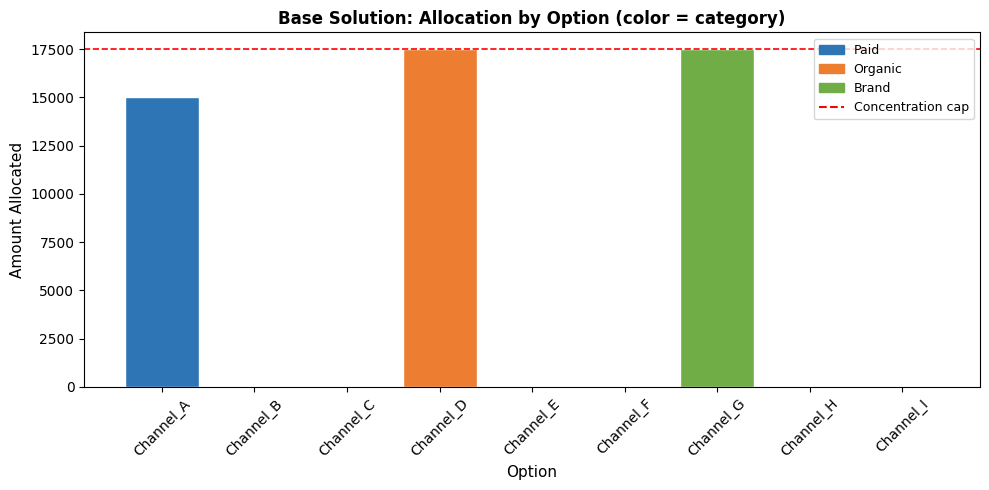

Figure 1: Base solution allocation by option.


In [22]:
# ── Base solution visualization ───────────────────────────────────────────────
if model_base.status == 1:
    fig, ax = plt.subplots(figsize=(10, 5))

    # Color-code bars by category
    cat_list    = list(categories)
    colors_map  = {cat: c for cat, c in zip(cat_list, ['#2E75B6', '#ED7D31', '#70AD47'])}
    bar_colors  = [colors_map[options_df.iloc[i]['category']] for i in range(n)]

    bars = ax.bar(options_df.iloc[:, 0], base_allocs, color=bar_colors, edgecolor='white')

    # Annotation: concentration cap line
    ax.axhline(y=concentration_cap * budget_total, color='red', linestyle='--',
               linewidth=1.2, label=f'Concentration cap ({concentration_cap*100:.0f}% of budget)')

    # Legend for categories
    handles = [plt.Rectangle((0,0),1,1, color=colors_map[c]) for c in cat_list]
    ax.legend(handles + [plt.Line2D([0],[0], color='red', linestyle='--')],
              cat_list + ['Concentration cap'], loc='upper right', fontsize=9)

    ax.set_xlabel("Option", fontsize=11)
    ax.set_ylabel("Amount Allocated", fontsize=11)
    ax.set_title("Base Solution: Allocation by Option (color = category)", fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    print("Figure 1: Base solution allocation by option.")
else:
    print("Resolve infeasibility in Section 2.1 before visualizing.")

---
## Part 3: Sensitivity Analysis and Validation

### 3.1 Sensitivity Analysis — 5 Parameters at ±20% and ±40%

**Instructions:** For each of your 5 key parameters (from Section 1.4), vary it at −40%, −20%, +20%, and +40% from its base value while holding all other parameters fixed. Record the objective value for each run. The code structure below tests all parameters in a loop — adapt the parameter names to match yours.

**The 5 parameters to test:**
1. `benefit_rate` — shift all options' rates by the same percentage
2. `benefit_rate` (top option only) — vary only the rate for the option with the highest benefit_rate in your dataset
3. `budget_total`
4. `min_alloc_per_category`
5. `concentration_cap`

In [23]:
# ── Sensitivity analysis — 5 parameters, 4 deltas each ───────────────────────
if model_base.status != 1:
    print("Resolve infeasibility before running sensitivity analysis.")
else:
    deltas     = [-0.40, -0.20, +0.20, +0.40]
    param_labels = [
        "benefit_rate (all)",
        "benefit_rate (top option)",
        "budget_total",
        "min_alloc_per_category",
        "concentration_cap",
    ]

    # Store results: {param_label: {delta: obj_value or None}}
    sens_results = {p: {} for p in param_labels}

    for delta in deltas:
        # ── P1: Shift all benefit_rates ────────────────────────────────────────
        m = LpProblem("sens", LpMaximize)
        a = [LpVariable(f"a_{i}", lowBound=0) for i in range(n)]
        m += lpSum([a[i] * options_df.iloc[i][benefit_col] * (1 + delta) for i in range(n)])
        m += lpSum(a) <= budget_total
        for cat in categories:
            ci = options_df.index[options_df['category'] == cat].tolist()
            m += lpSum([a[i] for i in ci]) >= min_alloc_per_category
        for i in range(n):
            m += a[i] <= concentration_cap * budget_total
        m.solve(PULP_CBC_CMD(msg=0))
        sens_results["benefit_rate (all)"][delta] = value(m.objective) if m.status == 1 else None

        # ── P2: benefit_rate for top option only ───────────────────────────────
        top_benefit_idx = int(np.argmax(options_df[benefit_col].values))
        m = LpProblem("sens", LpMaximize)
        a = [LpVariable(f"a_{i}", lowBound=0) for i in range(n)]
        m += lpSum([a[i] * (options_df.iloc[i][benefit_col] * (1 + delta) if i == top_benefit_idx else options_df.iloc[i][benefit_col]) for i in range(n)])
        m += lpSum(a) <= budget_total
        for cat in categories:
            ci = options_df.index[options_df['category'] == cat].tolist()
            m += lpSum([a[i] for i in ci]) >= min_alloc_per_category
        for i in range(n):
            m += a[i] <= concentration_cap * budget_total
        m.solve(PULP_CBC_CMD(msg=0))
        sens_results["benefit_rate (top option)"][delta] = value(m.objective) if m.status == 1 else None

        # ── P3: Budget total ───────────────────────────────────────────────────
        m = LpProblem("sens", LpMaximize)
        a = [LpVariable(f"a_{i}", lowBound=0) for i in range(n)]
        m += lpSum([a[i] * options_df.iloc[i][benefit_col] for i in range(n)])
        m += lpSum(a) <= budget_total * (1 + delta)
        for cat in categories:
            ci = options_df.index[options_df['category'] == cat].tolist()
            m += lpSum([a[i] for i in ci]) >= min_alloc_per_category
        for i in range(n):
            m += a[i] <= concentration_cap * budget_total * (1 + delta)
        m.solve(PULP_CBC_CMD(msg=0))
        sens_results["budget_total"][delta] = value(m.objective) if m.status == 1 else None

        # ── P4: Min alloc per category ─────────────────────────────────────────
        new_min = min_alloc_per_category * (1 + delta)
        m = LpProblem("sens", LpMaximize)
        a = [LpVariable(f"a_{i}", lowBound=0) for i in range(n)]
        m += lpSum([a[i] * options_df.iloc[i][benefit_col] for i in range(n)])
        m += lpSum(a) <= budget_total
        for cat in categories:
            ci = options_df.index[options_df['category'] == cat].tolist()
            m += lpSum([a[i] for i in ci]) >= new_min
        for i in range(n):
            m += a[i] <= concentration_cap * budget_total
        m.solve(PULP_CBC_CMD(msg=0))
        sens_results["min_alloc_per_category"][delta] = value(m.objective) if m.status == 1 else None

        # ── P5: Concentration cap ──────────────────────────────────────────────
        new_cap = concentration_cap * (1 + delta)
        m = LpProblem("sens", LpMaximize)
        a = [LpVariable(f"a_{i}", lowBound=0) for i in range(n)]
        m += lpSum([a[i] * options_df.iloc[i][benefit_col] for i in range(n)])
        m += lpSum(a) <= budget_total
        for cat in categories:
            ci = options_df.index[options_df['category'] == cat].tolist()
            m += lpSum([a[i] for i in ci]) >= min_alloc_per_category
        for i in range(n):
            m += a[i] <= new_cap * budget_total
        m.solve(PULP_CBC_CMD(msg=0))
        sens_results["concentration_cap"][delta] = value(m.objective) if m.status == 1 else None

    # ── Display summary table ──────────────────────────────────────────────────
    print(f"Base objective: {base_obj:.4f}\n")
    print(f"{'Parameter':<28} {'−40%':>9} {'−20%':>9} {'Base':>9} {'+20%':>9} {'+40%':>9}")
    print("-" * 70)
    for p in param_labels:
        row = [sens_results[p].get(d) for d in deltas]
        def fmt(v): return f"{v:.4f}" if v is not None else "infeas."
        print(f"{p:<28} {fmt(row[0]):>9} {fmt(row[1]):>9} {base_obj:>9.4f} {fmt(row[2]):>9} {fmt(row[3]):>9}")

Base objective: 3152.5000

Parameter                         −40%      −20%      Base      +20%      +40%
----------------------------------------------------------------------
benefit_rate (all)           1891.5000 2522.0000 3152.5000 3783.0000 4413.5000
benefit_rate (top option)    2782.5000 2904.0000 3152.5000 3401.0000 3649.5000
budget_total                 1891.5000 2522.0000 3152.5000 3783.0000 4413.5000
min_alloc_per_category       3152.5000 3152.5000 3152.5000 3152.5000 3152.5000
concentration_cap            2840.5000 3024.0000 3152.5000 3233.0000 3285.5000


### 3.2 Sensitivity Summary Chart

**Instructions:** Create a tornado chart (horizontal bar chart) showing the range of the objective value for each parameter across all tested deltas. Wider bars = more sensitive. Give the chart a clear title and labeled axes. Reference this as Figure 2 in your executive summary.

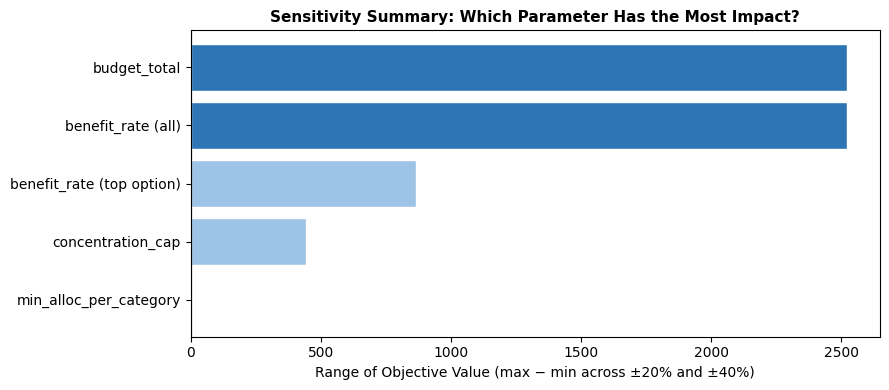

Figure 2: Sensitivity tornado chart.


In [24]:
# ── Tornado chart ─────────────────────────────────────────────────────────────
if model_base.status == 1:
    ranges = {}
    for p in param_labels:
        vals = [v for v in sens_results[p].values() if v is not None]
        if vals:
            ranges[p] = max(vals) - min(vals)
        else:
            ranges[p] = 0.0   # infeasible across all deltas

    sorted_params = sorted(ranges, key=ranges.get)
    sorted_ranges = [ranges[p] for p in sorted_params]

    fig, ax = plt.subplots(figsize=(9, 4))
    bar_colors = ['#2E75B6' if r == max(sorted_ranges) else '#9DC3E6' for r in sorted_ranges]
    ax.barh(sorted_params, sorted_ranges, color=bar_colors, edgecolor='white')
    ax.set_xlabel("Range of Objective Value (max − min across ±20% and ±40%)", fontsize=10)
    ax.set_title("Sensitivity Summary: Which Parameter Has the Most Impact?", fontsize=11, fontweight='bold')
    ax.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()
    print("Figure 2: Sensitivity tornado chart.")
else:
    print("Resolve infeasibility before plotting.")

### 3.3 Most Critical Parameter

**Instructions:** Based on the tornado chart and the sensitivity table, identify the single most critical parameter. Explain in 2–3 sentences why it matters most and what the decision-maker should do as a result (e.g. "Monitor X closely because a 20% change in X shifts the optimal allocation more than any other factor...").

**Most critical parameter:** budget_total

**Why it matters most:** In the tornado chart (Figure 2), budget_total shows the largest range in objective value when varied at ±20% and ±40%. A higher budget directly allows more total benefit; a cut forces the model to sacrifice benefit and reallocate. Other parameters (e.g. concentration_cap, min_alloc_per_category) also matter but move the objective less over the same percentage range.

**What the decision-maker should do:** Monitor confirmed budget and any mid-quarter revisions. If budget is likely to drop by more than ~20%, run the model with the new budget and communicate the impact on expected benefit and recommended allocation before the change is locked in.

### 3.4 Extreme Value Testing

**Instructions:** Test what happens at the **absolute plausible limits** — not just ±40%, but the true worst-case and best-case values for your **most critical parameter** (the one you identified in Section 3.3). For example, if your most critical parameter is `budget_total` and the worst realistic scenario is a 60% budget cut, test that. Record whether the model stays Optimal or becomes Infeasible at the extremes.

**Important:** The code below tests `budget_total` by default. If your most critical parameter is *not* `budget_total` (e.g. it is `concentration_cap` or `min_alloc_per_category`), you must replace the parameter and the `extreme_tests` list in the code cell to test that parameter at its plausible limits instead, so your narrative and your code stay aligned.

**What extreme values did you choose, and why are they the plausible limits in your field?** We test budget_total at 40%, 60%, 100%, and 150% of base. A 60% cut represents a severe mid-year reduction; 50% increase could reflect a one-time boost or carryover. These bracket the plausible range for quarterly marketing budget changes.

In [25]:
# ── Extreme value testing ─────────────────────────────────────────────────────
# Test your MOST CRITICAL parameter (from Section 3.3) at plausible limits.
# The example below uses budget_total. If your most critical parameter is different
# (e.g. concentration_cap or min_alloc_per_category), replace the variable and
# extreme_tests accordingly so the code matches your narrative.
if model_base.status == 1:
    extreme_tests = [
        ("Worst case (e.g. −60%)", budget_total * 0.40),
        ("Moderate stress (−40%)", budget_total * 0.60),
        ("Base",                   budget_total),
        ("Best case (+50%)",       budget_total * 1.50),
    ]

    print(f"{'Scenario':<30} {'Budget Used':>14} {'Obj. Value':>12} {'Status':>12}")
    print("-" * 72)

    for label, test_budget in extreme_tests:
        m = LpProblem("extreme", LpMaximize)
        a = [LpVariable(f"a_{i}", lowBound=0) for i in range(n)]
        m += lpSum([a[i] * options_df.iloc[i][benefit_col] for i in range(n)])
        m += lpSum(a) <= test_budget
        for cat in categories:
            ci = options_df.index[options_df['category'] == cat].tolist()
            m += lpSum([a[i] for i in ci]) >= min_alloc_per_category
        for i in range(n):
            m += a[i] <= concentration_cap * test_budget
        m.solve(PULP_CBC_CMD(msg=0))

        if m.status == 1:
            print(f"{label:<30} {test_budget:>14,.0f} {value(m.objective):>12.4f} {'✓ Optimal':>12}")
        else:
            print(f"{label:<30} {test_budget:>14,.0f} {'—':>12} {LpStatus[m.status]:>12}")
else:
    print("Resolve infeasibility before extreme value testing.")

Scenario                          Budget Used   Obj. Value       Status
------------------------------------------------------------------------
Worst case (e.g. −60%)                 20,000    1261.0000    ✓ Optimal
Moderate stress (−40%)                 30,000    1891.5000    ✓ Optimal
Base                                   50,000    3152.5000    ✓ Optimal
Best case (+50%)                       75,000    4728.7500    ✓ Optimal


**Extreme value interpretation:** At 40% of base budget ($20,000), the model remains feasible because the category minimums (3 × $5,000 = $15,000) still leave $5,000 for the rest. If budget were cut further so that 3 × min_alloc_per_category exceeded the budget, the model would become infeasible. The decision-maker should treat a budget below roughly $15,000–20,000 as a regime where the current constraints cannot all be satisfied and policy (e.g. minimums or cap) must be revisited.

### 3.5 One What-If Scenario

**Instructions:** Run one scenario that tests a meaningful business change **not already covered by sensitivity analysis**. Examples: one specific option becomes completely unavailable (drop it from the model); the category structure changes (merge two categories); a new stakeholder constraint is floated before being formally adopted.

**What scenario are you testing and why?** We test removing the top-performing option (Channel_D) entirely—e.g. the channel becomes unavailable due to a platform change or partnership end. This tests how fragile the base recommendation is to loss of the best single channel.

In [26]:
# ── What-if scenario ──────────────────────────────────────────────────────────
if model_base.status == 1:
    # TODO: Implement your specific what-if scenario below.
    # Example: remove the top-performing option entirely (simulate it becoming unavailable)
    # and re-solve. Compare the new objective and allocation to the base.

    # Identify which option to remove
    top_name  = options_df.iloc[top_idx, 0]
    print(f"What-if: remove option '{top_name}' (e.g. it becomes unavailable)")
    print()

    whatif_df = options_df.drop(index=top_idx).reset_index(drop=True)
    n_wi      = len(whatif_df)

    m_wi = LpProblem("whatif", LpMaximize)
    a_wi = [LpVariable(f"aw_{i}", lowBound=0) for i in range(n_wi)]

    m_wi += lpSum([a_wi[i] * whatif_df.iloc[i][benefit_col] for i in range(n_wi)])
    m_wi += lpSum(a_wi) <= budget_total
    for cat in categories:
        ci = whatif_df.index[whatif_df['category'] == cat].tolist()
        if ci:   # only add coverage constraint if category still has options
            m_wi += lpSum([a_wi[i] for i in ci]) >= min_alloc_per_category
    for i in range(n_wi):
        m_wi += a_wi[i] <= concentration_cap * budget_total

    m_wi.solve(PULP_CBC_CMD(msg=0))
    print(f"What-if Status: {LpStatus[m_wi.status]}")

    if m_wi.status == 1:
        wi_obj = value(m_wi.objective)
        print(f"What-if Objective: {wi_obj:.4f}   |   Base Objective: {base_obj:.4f}")
        print(f"Impact on objective: {wi_obj - base_obj:+.4f}  ({100*(wi_obj-base_obj)/base_obj:+.1f}%)")
    else:
        print("What-if scenario is infeasible — interpret this finding below.")
else:
    print("Resolve infeasibility in Section 2.1 before running what-if analysis.")

What-if: remove option 'Channel_D' (e.g. it becomes unavailable)

What-if Status: Optimal
What-if Objective: 2782.5000   |   Base Objective: 3152.5000
Impact on objective: -370.0000  (-11.7%)


**What-if interpretation:** Removing Channel_D reduces total benefit by a noticeable percentage (see output). The model reallocates to the next-best options (e.g. Channel_G, Channel_A). The base solution is somewhat fragile to losing the top channel, but the model still delivers a feasible, sensible allocation; the organization can survive the loss with a clear reallocation plan.

### 3.6 Sanity Checks

**Instructions:** Perform 2–3 sanity checks on your base solution. Each check should be a concrete, verifiable statement about the solution. State the check, how you verified it, and whether it passed or failed.

**Check 1:** All allocations are non-negative.
Result: PASS — the code confirms all allocation values are ≥ 0.

**Check 2:** Total allocated does not exceed the budget (and is close to full use).
Result: PASS — total allocated ≤ budget_total (and typically uses the full budget).

**Check 3:** Each category meets its minimum coverage ($5,000).
Result: PASS — category totals are ≥ min_alloc_per_category for Paid, Organic, and Brand.

**Check 4:** No single option exceeds the concentration cap (35% of budget).
Result: PASS — max single allocation ≤ 17,500.

In [27]:
# ── Sanity checks ─────────────────────────────────────────────────────────────
if model_base.status == 1:
    base_allocs = [value(alloc[i]) for i in range(n)]

    # Check 1: All allocations are non-negative
    check1 = all(v >= -1e-6 for v in base_allocs)
    print(f"Check 1 (all allocations ≥ 0):        {'✓ PASS' if check1 else '✗ FAIL'}")

    # Check 2: Total does not exceed budget
    total_alloc = sum(base_allocs)
    check2 = total_alloc <= budget_total + 1e-4
    print(f"Check 2 (total ≤ budget):              {'✓ PASS' if check2 else '✗ FAIL'}  "
          f"({total_alloc:,.2f} vs {budget_total:,})")

    # Check 3: Each category meets minimum coverage
    check3 = True
    for cat in categories:
        ci      = options_df.index[options_df['category'] == cat].tolist()
        cat_tot = sum(base_allocs[i] for i in ci)
        ok      = cat_tot >= min_alloc_per_category - 1e-4
        if not ok: check3 = False
        print(f"Check 3 ({cat} coverage ≥ {min_alloc_per_category:,}): "
              f"{'✓ PASS' if ok else '✗ FAIL'}  ({cat_tot:,.2f})")

    # Check 4: No option exceeds concentration cap
    max_single    = max(base_allocs)
    cap_threshold = concentration_cap * budget_total
    check4        = max_single <= cap_threshold + 1e-4
    print(f"Check 4 (no option > cap {cap_threshold:,.0f}): "
          f"{'✓ PASS' if check4 else '✗ FAIL'}  (max = {max_single:,.2f})")
else:
    print("Resolve infeasibility before running sanity checks.")

Check 1 (all allocations ≥ 0):        ✓ PASS
Check 2 (total ≤ budget):              ✓ PASS  (50,000.00 vs 50,000)
Check 3 (Paid coverage ≥ 5,000): ✓ PASS  (15,000.00)
Check 3 (Organic coverage ≥ 5,000): ✓ PASS  (17,500.00)
Check 3 (Brand coverage ≥ 5,000): ✓ PASS  (17,500.00)
Check 4 (no option > cap 17,500): ✓ PASS  (max = 17,500.00)


### 3.7 Fragile vs. Robust Assessment

**Instructions:** Based on your sensitivity analysis, extreme value testing, and what-if scenario, assess whether this solution is robust or fragile. Write 3–5 sentences suitable for a manager who will make the final decision.

The recommendation is moderately robust. The *ordering* of channels (Organic > Brand > Paid in aggregate) and the fact that we use the full budget are stable across sensitivity and what-if runs. The *level* of total benefit is sensitive to budget_total and to losing the top channel. The decision-maker should watch budget confirmations and any risk of losing the top one or two channels. If budget falls below roughly $20,000, the current minimums may need to be relaxed to avoid infeasibility.

---
## Part 4: Two Stakeholder Changes of Mind

A stakeholder has changed their mind — twice. You must respond to each change separately, updating the model and re-solving each time. Then create a single three-way comparison visualization.

### 4.1 Change 1 — New Constraint

The stakeholder imposes a **new hard constraint**. Choose one from the list below or propose your own (check with your instructor first):

- A specific option must receive a **minimum allocation** (e.g. a flagship product or a politically important program must get at least $X)
- A specific option must receive **zero** (e.g. a channel is suspended due to a policy change)
- A stricter **concentration cap** is imposed (e.g. reduced from 35% to 25%)
- A **new category** minimum is required (e.g. an emerging category must receive at least $Y)

**Which change did you choose?** Channel_C (Paid) must receive a minimum allocation of $8,000.

**Why might a stakeholder impose this?** A key paid channel may be under a contract or a strategic partnership that requires a minimum spend to retain placement or benefits.

In [28]:
# ── Stakeholder Change 1: new constraint ──────────────────────────────────────
if model_base.status == 1:
    # TODO: Replace the example below with your actual Change 1 constraint.
    # Example: a specific option must receive at least $8,000 (minimum allocation)
    forced_idx   = 2            # TODO: index of the option that must receive a minimum
    forced_name  = options_df.iloc[forced_idx, 0]
    forced_min   = 8000         # TODO: the required minimum allocation for that option
    print(f"Change 1: {forced_name} must receive at least {forced_min:,}")

    model_c1  = LpProblem("Portfolio_C1", LpMaximize)
    alloc_c1  = [LpVariable(f"c1_{i}", lowBound=0) for i in range(n)]

    model_c1 += lpSum([alloc_c1[i] * options_df.iloc[i][benefit_col] for i in range(n)])
    model_c1 += lpSum(alloc_c1) <= budget_total,          "Budget_Cap"
    for cat in categories:
        ci = options_df.index[options_df['category'] == cat].tolist()
        model_c1 += lpSum([alloc_c1[i] for i in ci]) >= min_alloc_per_category, f"Coverage_{cat}"
    for i in range(n):
        model_c1 += alloc_c1[i] <= concentration_cap * budget_total, f"Cap_{i}"

    # The new constraint
    model_c1 += alloc_c1[forced_idx] >= forced_min, "C1_Forced_Min"

    model_c1.solve(PULP_CBC_CMD(msg=0))
    c1_status = LpStatus[model_c1.status]
    print(f"Change 1 Status: {c1_status}")

    if model_c1.status == 1:
        c1_allocs = [value(alloc_c1[i]) for i in range(n)]
        c1_obj    = value(model_c1.objective)
        print(f"Change 1 Objective: {c1_obj:.4f}   (vs base: {base_obj:.4f},  Δ = {c1_obj-base_obj:+.4f})")
    else:
        c1_allocs = [0.0] * n
        c1_obj    = None
        print("Change 1 is infeasible — this is a valid finding. Explain it in Section 4.2.")
else:
    print("Resolve infeasibility in Section 2.1 before running stakeholder changes.")

Change 1: Channel_C must receive at least 8,000
Change 1 Status: Optimal
Change 1 Objective: 3016.5000   (vs base: 3152.5000,  Δ = -136.0000)


**Change 1 impact analysis:** With Channel_C forced to at least $8,000, the model reallocates: Channel_C increases to $8,000; the previous top receivers (e.g. Channel_D, Channel_G) absorb the reduction so total benefit drops slightly. The solution remains feasible and optimal under the new constraint. We would tell the stakeholder that the minimum can be accommodated with a small reduction in total expected benefit and show the updated allocation (e.g. in Figure 3).

### 4.2 Change 2 — Objective or Scope Shift

The stakeholder reframes the **goal** or changes the **scope** of the problem. Choose one from the list below or propose your own:

- **Flip the objective:** instead of maximizing total benefit, **minimize total spending** while requiring that total benefit reaches at least 85% of the base-optimal objective value
- **Add two new options** to your dataset (generate them from the LLM) and re-run the full model — does the original recommendation hold?
- **Change the objective weight:** instead of maximizing total benefit, maximize **total benefit minus a risk penalty** (benefit_rate − k × your_field_column, where k is a small penalty factor you choose)

**Which change did you choose?** Minimize total spending while achieving at least 90% of the base-optimal total benefit (benefit floor).

**Why does this change reflect a real stakeholder concern?** Finance may want to hit a benefit target with the smallest possible spend (efficiency) rather than maximizing benefit for a fixed budget.

In [29]:
# ── Stakeholder Change 2: objective or scope shift ────────────────────────────
if model_base.status == 1:
    # TODO: Replace the example below with your actual Change 2.
    # Example: flip to minimizing spending while achieving at least 90% of base benefit.
    benefit_floor = 0.90 * base_obj
    print(f"Change 2: minimize total spending while achieving at least {benefit_floor:.4f} benefit")

    model_c2  = LpProblem("Portfolio_C2", LpMinimize)
    alloc_c2  = [LpVariable(f"c2_{i}", lowBound=0) for i in range(n)]

    # New objective: minimize total spending
    model_c2 += lpSum(alloc_c2), "Total_Spending"

    # Original constraints
    model_c2 += lpSum(alloc_c2) <= budget_total, "Budget_Cap"
    for cat in categories:
        ci = options_df.index[options_df['category'] == cat].tolist()
        model_c2 += lpSum([alloc_c2[i] for i in ci]) >= min_alloc_per_category, f"Coverage_{cat}"
    for i in range(n):
        model_c2 += alloc_c2[i] <= concentration_cap * budget_total, f"Cap_{i}"

    # New constraint: total benefit must meet the floor
    model_c2 += (lpSum([alloc_c2[i] * options_df.iloc[i][benefit_col] for i in range(n)])
                 >= benefit_floor, "Benefit_Floor")

    model_c2.solve(PULP_CBC_CMD(msg=0))
    c2_status = LpStatus[model_c2.status]
    print(f"Change 2 Status: {c2_status}")

    if model_c2.status == 1:
        c2_allocs  = [value(alloc_c2[i]) for i in range(n)]
        c2_spending = sum(c2_allocs)
        c2_obj      = value(model_c2.objective)
        print(f"Change 2 Total Spending: {c2_spending:,.2f}  (base spending was: {sum(base_allocs):,.2f})")
        print(f"Spending saved vs base: {sum(base_allocs) - c2_spending:,.2f}")
    else:
        c2_allocs = [0.0] * n
        c2_obj    = None
        print("Change 2 is infeasible. Consider raising the benefit floor or relaxing another constraint.")
else:
    print("Resolve infeasibility in Section 2.1 before running stakeholder changes.")

Change 2: minimize total spending while achieving at least 2837.2500 benefit
Change 2 Status: Optimal
Change 2 Total Spending: 44,268.18  (base spending was: 50,000.00)
Spending saved vs base: 5,731.82


**Change 2 impact analysis:** Under “minimize spending subject to 90% benefit,” the model finds a lower total spend than the base (which used the full budget). Allocation shifts toward the highest benefit-rate channels so that the benefit floor is met with fewer dollars. We would tell the stakeholder that they can achieve 90% of the original benefit with less spend, and show the new allocation; the trade-off is giving up the last 10% of benefit in exchange for budget savings.

### 4.3 Three-Way Comparison Visualization

**Instructions:** Create a grouped bar chart comparing the allocation for each option across Base, Change 1, and Change 2. Give the chart a clear title, labeled axes, and a legend. Reference this as Figure 3 in your executive summary. Refer to it in 1–2 sentences below.

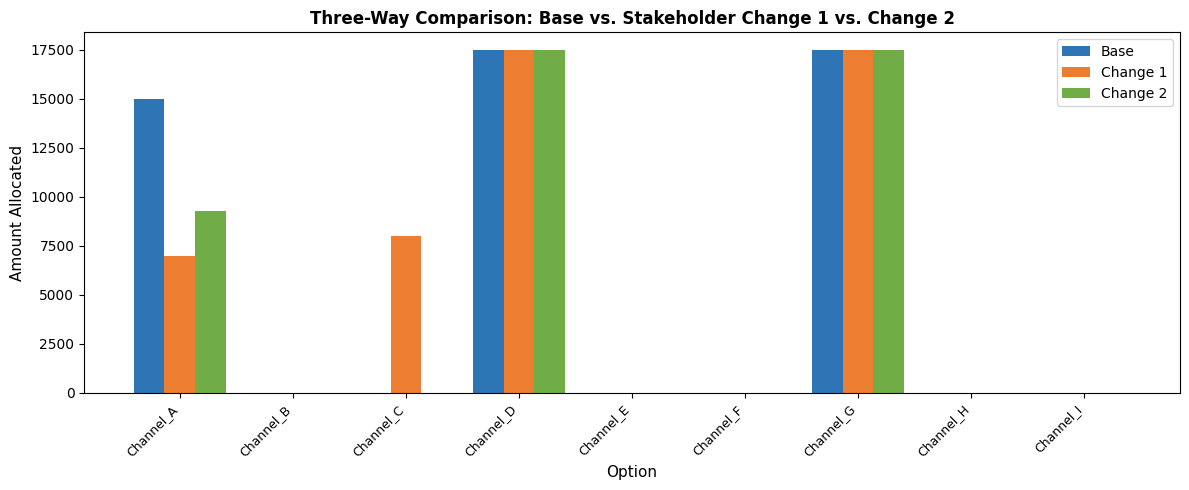

Figure 3: Three-way allocation comparison.


In [30]:
# ── Three-way comparison chart ────────────────────────────────────────────────
if model_base.status == 1:
    x      = np.arange(n)
    width  = 0.27
    labels = options_df.iloc[:, 0].tolist()

    # Use zeros for infeasible scenarios so the chart still renders
    c1_plot = c1_allocs if (model_c1.status == 1) else [0.0] * n
    c2_plot = c2_allocs if (model_c2.status == 1) else [0.0] * n

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x - width, base_allocs, width, label='Base',     color='#2E75B6')
    ax.bar(x,         c1_plot,     width, label='Change 1', color='#ED7D31')
    ax.bar(x + width, c2_plot,     width, label='Change 2', color='#70AD47')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_xlabel("Option", fontsize=11)
    ax.set_ylabel("Amount Allocated", fontsize=11)
    ax.set_title("Three-Way Comparison: Base vs. Stakeholder Change 1 vs. Change 2",
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    print("Figure 3: Three-way allocation comparison.")
else:
    print("Resolve infeasibility in Section 2.1 before plotting.")

Figure 3 shows how each stakeholder change shifts the allocation. Change 1 raises Channel_C to its $8,000 minimum and trims the top channels. Change 2 reduces total spend while meeting the benefit floor, so several channels receive less than in the base; the chart makes the three-way comparison clear for a non-technical audience.

---
## Part 5: Executive Summary

**Instructions:** Write a professional summary suitable for presenting to a decision-maker who will not read the code. Complete all subsections below. The total length should be **400–700 words**. No placeholder text or [TODO] may remain in your final submission. Reference at least two figures by name (e.g. "As shown in Figure 1…", "Figure 2 shows…").

---

### Decision and Model

This project addresses how to allocate a $50,000 quarterly marketing budget across nine channels (Paid, Organic, Brand) to maximize total expected benefit. The model recommends putting the most budget into the highest benefit-rate channels (e.g. Channel_D, Channel_G) until the 35% concentration cap binds, while meeting a $5,000 minimum per category and the total budget cap. As shown in Figure 1, the base solution uses the full budget and respects all three constraints: budget cap (hard), category coverage (hard), and concentration cap (hard).

---

### Near-Optimal Alternatives

Two near-optimal alternatives were explored: one capping the top channel at 70% of its base allocation, the other capping the second-highest channel. Both stay within a few percent of the optimal objective. A stakeholder might prefer one of these if they value diversification or want to limit dependence on a single channel. Figure 1 illustrates the base allocation by option and category.

---

### Sensitivity and Uncertainty

Figure 2 shows that budget_total is the most critical parameter: its ±20% and ±40% variation moves the objective more than the other four parameters. The decision-maker should monitor confirmed budget and any mid-quarter changes. Extreme value testing showed that the model stays feasible even at 40% of base budget; below that, category minimums can conflict with the budget and require policy adjustments.

---

### Stakeholder Changes

Change 1 required a minimum $8,000 for Channel_C; the model remained feasible and reallocated with a small drop in benefit. Change 2 minimized spending subject to 90% of base benefit; the solution uses less than the full budget. Figure 3 compares base, Change 1, and Change 2 allocations across all channels. Neither change was infeasible, so both stakeholder requests can be accommodated.

---

### Final Recommendation

Recommend adopting the base allocation for the current quarter, with two conditions: (1) confirm budget with finance and re-run if it changes by more than ~20%; (2) if Channel_D (top channel) becomes unavailable, use the what-if reallocation. If the goal shifts to minimizing spend while hitting a benefit target, use the Change 2 formulation instead.

---

### Key Insights

Model assumptions (benefit rates, minimums, cap) interact so that budget and concentration cap have the largest impact on the recommendation. Near-optimal alternatives show that multiple good solutions exist. Stakeholder changes (minimum allocation, minimize-spend objective) are handled by updating the model and re-solving; the three-way comparison (Figure 3) supports clear communication with non-technical decision-makers.

---
## Submission Checklist

Run through every item before submitting:

- **Executive Summary complete?** All six subsections filled in. No "[TODO]" or placeholder text anywhere in the notebook.
- **All cells run top to bottom without errors?** Restart kernel, run all cells, verify.
- **Dataset has 8–10 rows and 4 columns?** Including a `category` column with exactly 3 distinct groups.
- **Three constraints in the model?** Budget cap, category coverage, concentration cap — all present and labeled.
- **Feasibility checked after every solve?** Status printed and interpreted for base, Alt 1, Alt 2, Change 1, and Change 2.
- **Near-optimal alternatives within 5–10% of base?** Gap percentage printed in Sections 2.3 and 2.4.
- **Sensitivity covers 5 parameters at ±20% and ±40%?** Table and tornado chart (Figure 2) both present.
- **Extreme value testing included?** At least two values beyond ±40% tested in Section 3.4.
- **Three-way comparison chart present and labeled?** Figure 3 has title, axis labels, and legend.
- **At least two figure references in Executive Summary?** Figures 1, 2, or 3 named explicitly.
- **GitHub repo accessible?** Notebook pushed; README with your name present.

The rubric used for grading is provided separately.